<a href="https://colab.research.google.com/github/git4sudo/miscellaneous/blob/main/Multi_Column_Face_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!unzip '/content/gdrive/MyDrive/Ann final/hyperverge-2022-intern-challenge.zip' > /dev/null

In [ ]:
import numpy as np 
import pandas as pd
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
df = pd.read_csv('/content/train.csv')

In [ ]:
df.head()

,file,age,gender,race
0,train/1.jpg,50-59,Male,East Asian
1,train/2.jpg,30-39,Female,Indian
2,train/3.jpg,3-9,Female,Black
3,train/4.jpg,20-29,Female,Indian
4,train/5.jpg,20-29,Female,Indian


In [ ]:
dataset_dict = {
    'race_id' : {
        0: 'East Asian',
        1: 'Indian',
        2: 'Black',
        3: 'White',
        4: 'Middle Eastern',
        5: 'Latino_Hispanic',
        6: 'Southeast Asian'
    },
    'gender_id': {
        0: 'Male',
        1: 'Female'
    },
    'age_id': {0: '0-2',
               1: '3-9',
               2: '10-19',
               3: '20-29',
               4: '30-39',
               5: '40-49',
               6: '50-59',
               7: '60-69',
               8: 'more than 70'}

}

dataset_dict['age_alias'] = dict((g, i) for i, g in dataset_dict['age_id'].items())
dataset_dict['gender_alias'] = dict((g, i) for i, g in dataset_dict['gender_id'].items())
dataset_dict['race_alias'] = dict((g, i) for i, g in dataset_dict['race_id'].items())

In [ ]:
dataset_dict

{'age_alias': {'0-2': 0,
  '10-19': 2,
  '20-29': 3,
  '3-9': 1,
  '30-39': 4,
  '40-49': 5,
  '50-59': 6,
  '60-69': 7,
  'more than 70': 8},
 'age_id': {0: '0-2',
  1: '3-9',
  2: '10-19',
  3: '20-29',
  4: '30-39',
  5: '40-49',
  6: '50-59',
  7: '60-69',
  8: 'more than 70'},
 'gender_alias': {'Female': 1, 'Male': 0},
 'gender_id': {0: 'Male', 1: 'Female'},
 'race_alias': {'Black': 2,
  'East Asian': 0,
  'Indian': 1,
  'Latino_Hispanic': 5,
  'Middle Eastern': 4,
  'Southeast Asian': 6,
  'White': 3},
 'race_id': {0: 'East Asian',
  1: 'Indian',
  2: 'Black',
  3: 'White',
  4: 'Middle Eastern',
  5: 'Latino_Hispanic',
  6: 'Southeast Asian'}}

In [ ]:
dataset_folder_name = '/content/train'
TRAIN_TEST_SPLIT = 1
IM_WIDTH = IM_HEIGHT = 198

In [ ]:
from tensorflow.keras.utils import to_categorical
from PIL import Image

class UtkFaceDataGenerator():
    """
    Data generator for the UTKFace dataset. This class should be used when training our Keras multi-output model.
    """
    def __init__(self, df):
        self.df = df
        
    def generate_split_indexes(self):
        p = np.random.permutation(len(self.df))
        train_up_to = int(len(self.df) * TRAIN_TEST_SPLIT)
        train_idx = p[:train_up_to]
        test_idx = p[train_up_to:]

        train_up_to = int(train_up_to * TRAIN_TEST_SPLIT)
        train_idx, valid_idx = train_idx[:train_up_to], train_idx[train_up_to:]
        
        # converts alias to id
        self.df['age_id'] = self.df['age'].map(lambda age: dataset_dict['age_alias'][age])
        self.df['gender_id'] = self.df['gender'].map(lambda gender: dataset_dict['gender_alias'][gender])
        self.df['race_id'] = self.df['race'].map(lambda race: dataset_dict['race_alias'][race])

        # self.max_age = self.df['age'].max()
        
        return train_idx, valid_idx, test_idx

    def preprocess_image(self, img_path):
        """
        Used to perform some minor preprocessing on the image before inputting into the network.
        """
        im = Image.open(img_path)
        im = im.resize((IM_WIDTH, IM_HEIGHT))
        im = np.array(im) / 255.0
        
        return im
        
    def generate_images(self, image_idx, is_training, batch_size=16):
        """
        Used to generate a batch with images when training/testing/validating our Keras model.
        """
        
        # arrays to store our batched data
        images, ages, races, genders = [], [], [], []
        while True:
            for idx in image_idx:
                person = self.df.iloc[idx]
                
                age = person['age_id']
                race = person['race_id']
                gender = person['gender_id']
                file = person['file']
                
                im = self.preprocess_image(file)
                
                # ages.append(age / self.max_age)
                ages.append(to_categorical(age, len(dataset_dict['age_id'])))
                races.append(to_categorical(race, len(dataset_dict['race_id'])))
                genders.append(to_categorical(gender, len(dataset_dict['gender_id'])))
                images.append(im)
                
                # yielding condition
                if len(images) >= batch_size:
                    yield np.array(images), [np.array(ages), np.array(races), np.array(genders)]
                    images, ages, races, genders = [], [], [], []
                    
            if not is_training:
                break
                
data_generator = UtkFaceDataGenerator(df)
train_idx, valid_idx, test_idx = data_generator.generate_split_indexes()

In [ ]:
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Lambda
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
import tensorflow as tf

class UtkMultiOutputModel():
    """
    Used to generate our multi-output model. This CNN contains three branches, one for age, other for 
    sex and another for race. Each branch contains a sequence of Convolutional Layers that is defined
    on the make_default_hidden_layers method.
    """
    def make_default_hidden_layers(self, inputs):
        """
        Used to generate a default set of hidden layers. The structure used in this network is defined as:
        
        Conv2D -> BatchNormalization -> Pooling -> Dropout
        """
        x = Conv2D(16, (3, 3), padding="same")(inputs)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(3, 3))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        x = Conv2D(32, (3, 3), padding="same")(x)
        x = Activation("relu")(x)
        x = BatchNormalization(axis=-1)(x)
        x = MaxPooling2D(pool_size=(2, 2))(x)
        x = Dropout(0.25)(x)

        return x

    def build_race_branch(self, inputs, num_races):
        """
        Used to build the race branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_races)(x)
        x = Activation("softmax", name="race_output")(x)

        return x

    def build_gender_branch(self, inputs, num_genders=2):
        """
        Used to build the gender branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.
        """
        x = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(inputs)

        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(num_genders)(x)
        x = Activation("sigmoid", name="gender_output")(x)

        return x

    def build_age_branch(self, inputs, num_ages=9):   
        """
        Used to build the age branch of our face recognition network.
        This branch is composed of three Conv -> BN -> Pool -> Dropout blocks, 
        followed by the Dense output layer.

        """
        x = self.make_default_hidden_layers(inputs)

        x = Flatten()(x)
        x = Dense(128)(x)
        x = Activation("relu")(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        # x = Dense(1)(x)
        # x = Activation("linear", name="age_output")(x)
        x = Dense(num_ages)(x)
        x = Activation("sigmoid", name="age_output")(x)

        return x

    def assemble_full_model(self, width, height, num_races):
        """
        Used to assemble our multi-output model CNN.
        """
        input_shape = (height, width, 3)

        inputs = Input(shape=input_shape)

        age_branch = self.build_age_branch(inputs)
        race_branch = self.build_race_branch(inputs, num_races)
        gender_branch = self.build_gender_branch(inputs)

        model = Model(inputs=inputs,
                     outputs = [age_branch, race_branch, gender_branch],
                     name="face_net")

        return model
    
model = UtkMultiOutputModel().assemble_full_model(IM_WIDTH, IM_HEIGHT, num_races=len(dataset_dict['race_alias']))

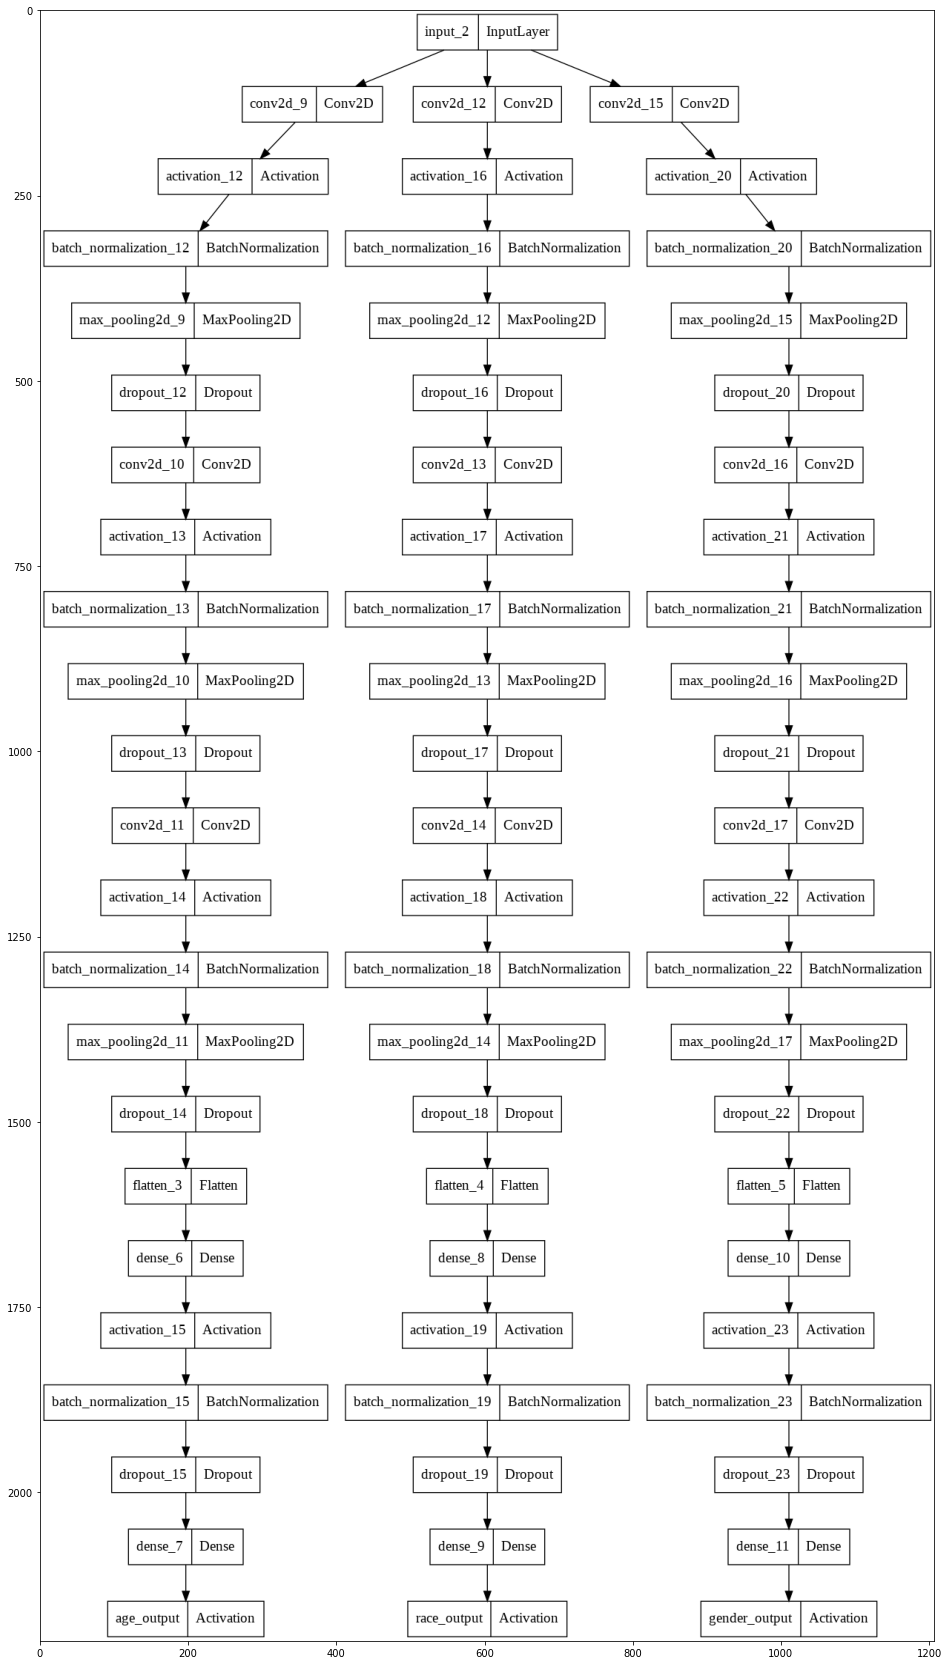

In [ ]:
%matplotlib inline

from keras.utils.vis_utils import plot_model
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

plot_model(model, to_file='model.png')
img = mpimg.imread('model.png')

plt.figure(figsize=(40, 30))
plt.imshow(img)

In [ ]:
model.summary()

Model: "face_net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 198, 198, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 198, 198, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_12 (Conv2D)             (None, 198, 198, 16  448         ['input_2[0][0]']                
                                )                                                          

In [ ]:
from tensorflow.keras.optimizers import Adam

init_lr = 1e-4
epochs = 100

opt = Adam(lr=init_lr, decay=init_lr / epochs)

model.compile(optimizer=opt, 
              loss={
                  'age_output': 'categorical_crossentropy', 
                  'race_output': 'categorical_crossentropy', 
                  'gender_output': 'binary_crossentropy'},
              loss_weights={
                  'age_output': 0.1, 
                  'race_output': 1.5, 
                  'gender_output': 0.1},
              metrics={
                  'age_output': 'accuracy', 
                  'race_output': 'accuracy',
                  'gender_output': 'accuracy'})

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
print(train_gen)

<generator object UtkFaceDataGenerator.generate_images at 0x7fb189f1f4d0>


In [ ]:
from keras.callbacks import ModelCheckpoint

batch_size = 32
valid_batch_size = 32
train_gen = data_generator.generate_images(train_idx, is_training=True, batch_size=batch_size)
valid_gen = data_generator.generate_images(valid_idx, is_training=True, batch_size=valid_batch_size)

callbacks = [
    ModelCheckpoint("./model_checkpoint", monitor='val_loss')
]

history = model.fit_generator(train_gen,
                    steps_per_epoch=len(train_idx)//batch_size,
                    epochs=epochs,
                    callbacks=callbacks,
                    validation_data=valid_gen,
                    validation_steps=len(valid_idx)//valid_batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/100


KeyboardInterrupt: ignored

In [ ]:
dft = pd.read_csv('/content/test.csv')
dft = dft.assign(age='20-29')
dft = dft.assign(gender='Male')
dft = dft.assign(race='Indian')
dft.head()

In [ ]:
dataset_folder_name = '/content/test'
TRAIN_TEST_SPLIT = 0
IM_WIDTH = IM_HEIGHT = 198

In [ ]:
data_generator = UtkFaceDataGenerator(dft)
train_idx, valid_idx, test_idx = data_generator.generate_split_indexes()

In [ ]:
test_batch_size = 1
test_generator = data_generator.generate_images(test_idx, is_training=False, batch_size=test_batch_size)
age_pred, race_pred, gender_pred = model.predict_generator(test_generator, 
                                                           steps=len(test_idx)//test_batch_size)

In [ ]:
age_class = age_pred.argmax(axis=-1)
race_class = race_pred.argmax(axis=-1)
gender_class = gender_pred.argmax(axis=-1)

In [ ]:
img_idx = 52
print(dataset_dict['age_id'][age_class[img_idx]], 
      dataset_dict['gender_id'][gender_class[img_idx]], 
      dataset_dict['race_id'][race_class[img_idx]])

In [ ]:
f = []
a = []
g = []
r = []
for i in range(len(test_idx)):
  name = "test/" + str(i + 1) + ".jpg"
  f.append(name)
  a.append(dataset_dict['age_id'][age_class[i]])
  g.append(dataset_dict['gender_id'][gender_class[i]])
  r.append(dataset_dict['race_id'][race_class[i]])

In [ ]:
f[0]

In [ ]:
final = pd.DataFrame(list(zip(f, a, g, r)),
                     columns =['file', 'age', 'gender', 'race'])

In [ ]:
final.head()

In [ ]:
final.to_csv('final_output1.csv', index=False)